In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import copy


In [ ]:
# Load your dataset
df3 = pd.read_csv("/content/column_3C_weka.csv")


In [ ]:
df3.head()

,pelvic_incidence,pelvic_tilt,lumbar_lordosis_angle,sacral_slope,pelvic_radius,degree_spondylolisthesis,class
0,63.027817,22.552586,39.609117,40.475232,98.672917,-0.254400,Hernia
1,39.056951,10.060991,25.015378,28.995960,114.405425,4.564259,Hernia
2,68.832021,22.218482,50.092194,46.613539,105.985135,-3.530317,Hernia
3,69.297008,24.652878,44.311238,44.644130,101.868495,11.211523,Hernia
4,49.712859,9.652075,28.317406,40.060784,108.168725,7.918501,Hernia


In [ ]:
# Encode class labels
label_encoder = LabelEncoder()
df3['class'] = label_encoder.fit_transform(df3['class'])

# Split features and labels
X = df3.drop(columns=['class']).values.astype(np.float32)
y = df3['class'].values.astype(np.int64)

In [ ]:
df3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 310 entries, 0 to 309
Data columns (total 7 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   pelvic_incidence          310 non-null    float64
 1   pelvic_tilt               310 non-null    float64
 2   lumbar_lordosis_angle     310 non-null    float64
 3   sacral_slope              310 non-null    float64
 4   pelvic_radius             310 non-null    float64
 5   degree_spondylolisthesis  310 non-null    float64
 6   class                     310 non-null    int64  
dtypes: float64(6), int64(1)
memory usage: 17.1 KB


In [ ]:
# Rename columns (remove spaces and tidy up names)
df3.rename(columns=lambda x: x.strip().replace(" ", "_"), inplace=True)

In [ ]:
#  Check for missing values
print("Missing values in each column:")
print(df3.isnull().sum())

Missing values in each column:
pelvic_incidence            0
pelvic_tilt                 0
lumbar_lordosis_angle       0
sacral_slope                0
pelvic_radius               0
degree_spondylolisthesis    0
class                       0
dtype: int64


In [ ]:
# Convert class column to categorical type
df3['class'] = df3['class'].astype('category')

In [ ]:
print(df3['class'].value_counts())

class
2    150
1    100
0     60
Name: count, dtype: int64


In [ ]:
from sklearn.utils import resample
import pandas as pd

# Assuming `df` is your dataset and the class column is named 'class'

# Separate classes
class_0 = df3[df3['class'] == 0]
class_1 = df3[df3['class'] == 1]
class_2 = df3[df3['class'] == 2]

# Find the maximum class size
max_size = max(len(class_0), len(class_1), len(class_2))

# Upsample minority classes
class_0_upsampled = resample(class_0, replace=True, n_samples=max_size, random_state=42)
class_1_upsampled = resample(class_1, replace=True, n_samples=max_size, random_state=42)

# Combine all classes
df= pd.concat([class_2, class_1_upsampled, class_0_upsampled])

# Shuffle the dataset
df= df.sample(frac=1, random_state=42).reset_index(drop=True)

# Check new class distribution
print(df['class'].value_counts())


class
0    150
1    150
2    150
Name: count, dtype: int64


In [ ]:
# Feature Scaling
from sklearn.preprocessing import StandardScaler
scaler3 = StandardScaler()
features3 = df.columns[:-1]  # All columns except 'class'
df3_scaled = df.copy()
df3_scaled[features3] = scaler3.fit_transform(df[features3])

In [ ]:
# Train-Test Split
X3 = df3_scaled.drop('class', axis=1)
y3 = df3_scaled['class']
X3_train, X3_test, y3_train, y3_test = train_test_split(X3, y3, test_size=0.2, random_state=42)
X3

,pelvic_incidence,pelvic_tilt,lumbar_lordosis_angle,sacral_slope,pelvic_radius,degree_spondylolisthesis
0,-0.072000,-0.133503,0.801018,0.002622,-0.366430,-0.641880
1,-0.821458,-0.110613,-0.041292,-0.960747,-0.774597,-0.299767
2,1.420236,0.185600,0.766123,1.665013,-2.475459,0.763423
3,1.470701,1.217413,0.578109,1.005152,-0.302283,0.353606
4,-0.548852,-0.281842,-0.671858,-0.496083,0.495464,-0.331351
...,...,...,...,...,...,...
445,-0.014136,-1.155978,0.510625,0.792861,-0.713914,0.541036
446,0.349171,1.064144,0.212638,-0.304969,-0.324897,-0.346707
447,-0.835386,-1.091597,-1.085379,-0.290353,-0.473545,-0.397685
448,0.142636,1.569967,-0.065540,-0.920781,0.089478,-0.527022


In [ ]:
# Split into client datasets (4 clients as in the reference repo)
def split_data(X, y, num_clients=2):
    data_per_client = len(X) // num_clients
    client_data = []
    for i in range(num_clients):
        start = i * data_per_client
        end = (i + 1) * data_per_client if i != num_clients - 1 else len(X)
        client_X = X[start:end]
        client_y = y[start:end]
        client_data.append(TensorDataset(torch.tensor(client_X), torch.tensor(client_y)))
    return client_data

client_datasets = split_data(X, y)


In [ ]:
class OrthoNet(nn.Module):
    def __init__(self):
        super(OrthoNet, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(6, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 3)
        )

    def forward(self, x):
        return self.net(x)

In [ ]:
# Federated averaging
def federated_avg(models):
    global_model = copy.deepcopy(models[0])
    for key in global_model.state_dict().keys():
        for i in range(1, len(models)):
            global_model.state_dict()[key] += models[i].state_dict()[key]
        global_model.state_dict()[key] = torch.div(global_model.state_dict()[key], len(models))
    return global_model


In [ ]:
from sklearn.utils.class_weight import compute_class_weight

classes = np.unique(y3_train)
weights = compute_class_weight('balanced', classes=classes, y=y3_train)
weights_tensor = torch.tensor(weights, dtype=torch.float32)

criterion = nn.CrossEntropyLoss(weight=weights_tensor)


In [ ]:
# Training on a single client
def train_client(model, dataset, epochs=20):
    model.train()
    optimizer = torch.optim.AdamW(model.parameters(), lr=0.005, weight_decay=1e-4)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.7)
    criterion = nn.CrossEntropyLoss()
    loader = DataLoader(dataset, batch_size=16, shuffle=True)

    for _ in range(epochs):
        for x_batch, y_batch in loader:
            optimizer.zero_grad()
            preds = model(x_batch)
            loss = criterion(preds, y_batch)
            loss.backward()
            optimizer.step()
            scheduler.step()
    return model


In [ ]:
# Evaluate model
def evaluate_model(model, X_test, y_test):
    model.eval()
    with torch.no_grad():
        X_test = torch.tensor(X_test)
        y_test = torch.tensor(y_test)
        outputs = model(X_test)
        _, predicted = torch.max(outputs, 1)
        accuracy = (predicted == y_test).sum().item() / y_test.size(0)
        return accuracy

# Central test split for final evaluation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [ ]:
# Federated training loop
global_model = OrthoNet()
rounds = 20

for rnd in range(rounds):
    print(f"\n--- Round {rnd+1} ---")
    local_models = []

    # Train on each client
    for i, dataset in enumerate(client_datasets):
        local_model = copy.deepcopy(global_model)
        local_model = train_client(local_model, dataset)
        local_models.append(local_model)
        print(f"Client {i+1} done training.")

    # Federated averaging
    global_model = federated_avg(local_models)

    # Evaluation
    acc = evaluate_model(global_model, X_test, y_test)
    print(f"Round {rnd+1} Accuracy on global test set: {acc:.4f}")

print("\nTraining complete.")


--- Round 1 ---
Client 1 done training.
Client 2 done training.
Round 1 Accuracy on global test set: 0.7581

--- Round 2 ---
Client 1 done training.
Client 2 done training.
Round 2 Accuracy on global test set: 0.8065

--- Round 3 ---
Client 1 done training.
Client 2 done training.
Round 3 Accuracy on global test set: 0.8871

--- Round 4 ---
Client 1 done training.
Client 2 done training.
Round 4 Accuracy on global test set: 0.9032

--- Round 5 ---
Client 1 done training.
Client 2 done training.
Round 5 Accuracy on global test set: 0.9032

--- Round 6 ---
Client 1 done training.
Client 2 done training.
Round 6 Accuracy on global test set: 0.9032

--- Round 7 ---
Client 1 done training.
Client 2 done training.
Round 7 Accuracy on global test set: 0.9032

--- Round 8 ---
Client 1 done training.
Client 2 done training.
Round 8 Accuracy on global test set: 0.9032

--- Round 9 ---
Client 1 done training.
Client 2 done training.
Round 9 Accuracy on global test set: 0.9032

--- Round 10 ---
C

In [ ]:
# Get the mapping from number to label
label_map = {i: label for i, label in enumerate(label_encoder.classes_)}


In [ ]:
# Pick a few samples from the test set
num_test_cases = 5
X_sample = X_test[:num_test_cases]
y_sample = y_test[:num_test_cases]

# Get model predictions
global_model.eval()
with torch.no_grad():
    inputs = torch.tensor(X_sample)
    outputs = global_model(inputs)
    _, preds = torch.max(outputs, 1)

# Show test case predictions
print("\n📋 Sample Test Cases:")
for i in range(num_test_cases):
    actual = label_map[y_sample[i]]
    predicted = label_map[preds[i].item()]
    print(f"Test Case {i+1}: Predicted = {predicted}, Actual = {actual}")



📋 Sample Test Cases:
Test Case 1: Predicted = Normal, Actual = Normal
Test Case 2: Predicted = Spondylolisthesis, Actual = Spondylolisthesis
Test Case 3: Predicted = Spondylolisthesis, Actual = Spondylolisthesis
Test Case 4: Predicted = Normal, Actual = Normal
Test Case 5: Predicted = Hernia, Actual = Normal


In [ ]:
final_accuracy = evaluate_model(global_model, X_test, y_test)
print(f"\n Final Test Accuracy after {rounds} rounds: {final_accuracy * 100:.2f}%")



 Final Test Accuracy after 20 rounds: 90.32%


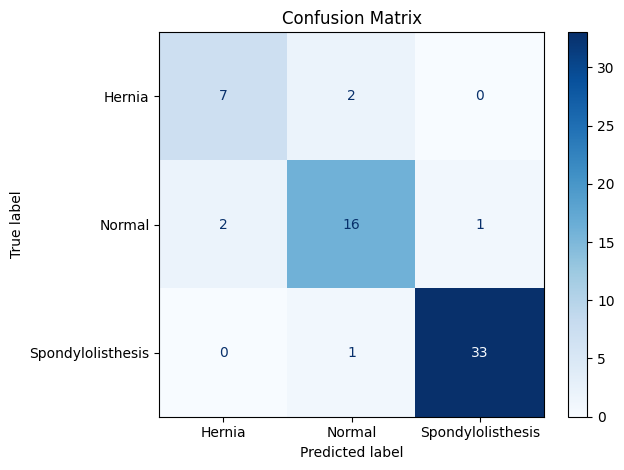

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Evaluate predictions on test set
global_model.eval()
with torch.no_grad():
    test_inputs = torch.tensor(X_test)
    test_outputs = global_model(test_inputs)
    _, y_pred = torch.max(test_outputs, 1)

# Confusion matrix
cm = confusion_matrix(y_test, y_pred.numpy())
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()

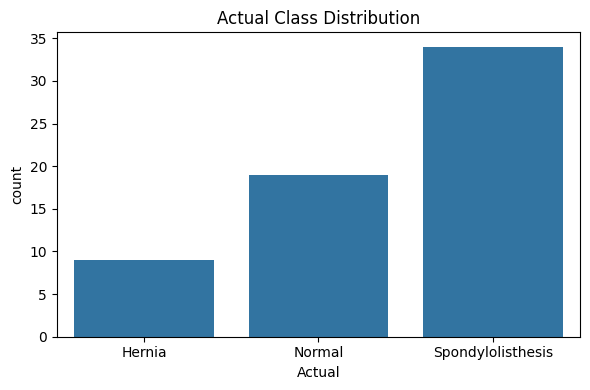

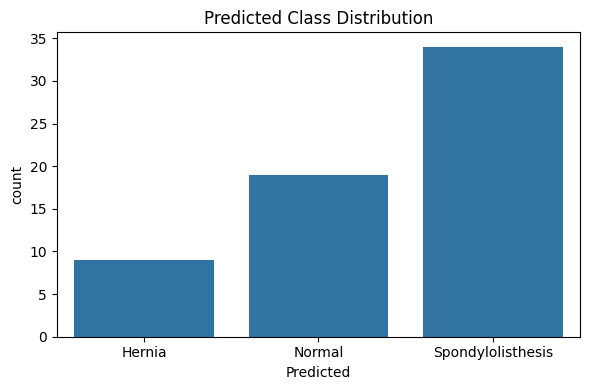

In [ ]:
import pandas as pd

# Actual and predicted class names
actual_classes = [label_encoder.classes_[i] for i in y_test]
predicted_classes = [label_encoder.classes_[i] for i in y_pred]

# Create DataFrame for plotting
comparison_df = pd.DataFrame({
    'Actual': actual_classes,
    'Predicted': predicted_classes
})

# Bar plot – actual distribution
plt.figure(figsize=(6, 4))
sns.countplot(x='Actual', data=comparison_df, order=label_encoder.classes_)
plt.title("Actual Class Distribution")
plt.tight_layout()
plt.show()

# Bar plot – predicted distribution
plt.figure(figsize=(6, 4))
sns.countplot(x='Predicted', data=comparison_df, order=label_encoder.classes_)
plt.title("Predicted Class Distribution")
plt.tight_layout()
plt.show()

In [ ]:
pd.DataFrame(X_train).describe()
# Convert X_train back to a DataFrame with original column names
X_train_df = pd.DataFrame(X_train, columns=df.columns[:-1])
X_train_df.describe()


,pelvic_incidence,pelvic_tilt,lumbar_lordosis_angle,sacral_slope,pelvic_radius,degree_spondylolisthesis
count,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000
mean,59.921978,17.321058,51.561863,42.600922,118.023872,25.044744
std,17.157824,9.505501,18.338848,13.570822,13.221631,38.043259
min,26.147921,-6.554948,14.000000,13.366931,70.082573,-11.058179
25%,46.386216,10.738883,36.563208,33.309342,111.206528,1.557704
50%,57.216398,16.015145,48.889297,42.147730,118.353355,10.656214
75%,72.112793,21.823871,62.894331,51.070263,125.205648,39.570278
max,129.834045,49.431862,125.742386,121.429565,163.071045,418.543091


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
model3 = RandomForestClassifier(random_state=42)
model3.fit(X3_train, y3_train)
y3_pred = model3.predict(X3_test)
print("Classification Report:")
print(classification_report(y3_test, y3_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.92      0.86        26
           1       0.90      0.81      0.85        32
           2       1.00      0.97      0.98        32

    accuracy                           0.90        90
   macro avg       0.90      0.90      0.90        90
weighted avg       0.91      0.90      0.90        90



In [ ]:
# Training accuracy
train_preds = model3.predict(X3_train)
train_accuracy = accuracy_score(y3_train, train_preds)
print(f"Training Accuracy: {train_accuracy:.2f}")

# Testing accuracy
test_preds = model3.predict(X3_test)
test_accuracy = accuracy_score(y3_test, test_preds)
print(f"Testing Accuracy: {test_accuracy:.2f}")

Training Accuracy: 1.00
Testing Accuracy: 0.90
